In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.inspection import (
    permutation_importance, PartialDependenceDisplay
)

from imblearn.over_sampling import RandomOverSampler
from scipy.stats import randint, uniform, reciprocal, expon
from sklearn.ensemble import RandomForestClassifier


In [8]:
#General eval metrics
def evaluate_predictions(meta_df, probs, target):
    df = meta_df.copy()
    df[f'prob_{target}'] = probs

    df = df.sort_values(by=['year', 'event', 'GridPosition'])
    df[f'rank_{target}'] = df.groupby('event')[f'prob_{target}'].rank(ascending=False, method='first')

    first_place_acc = (df[df["Position"] == 1][f'rank_{target}'] == 1).mean()
    df['is_podium_actual'] = df["Position"].isin([1, 2, 3])
    df['is_podium_predicted'] = df[f'rank_{target}'] <= 3
    podium_acc = (df['is_podium_actual'] == df['is_podium_predicted']).mean()
    total_rank_acc = (df["Position"] == df[f'rank_{target}']).mean()

    print(f"\nEvaluation - Target: {target}")
    print("First place accuracy:", round(first_place_acc, 4))
    print("Podium accuracy:", round(podium_acc, 4))
    print("Exact position accuracy:", round(total_rank_acc, 4))

    return df


In [9]:
#Permutation Importance (mandatory)
def plot_permutation_importance(model, X_test, y_test, feature_names, target):
    print("\nComputing permutation importance...")
    result = permutation_importance(
        model, X_test, y_test, n_repeats=20, random_state=42, scoring="roc_auc"
    )

    sorted_idx = result.importances_mean.argsort()[::-1][:20]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"Permutation Importance – {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [10]:
#PDP (mandatory)
def plot_top_pdp(model, X, feature_names, top_n=6):
    print(f"\n Partial Dependence on Top {top_n} Features:")
    
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    
    top_features = []
    for idx in sorted_idx:
        fname = feature_names[idx]
        if fname in X.columns and X[fname].nunique() > 5 and not fname.startswith(('event_', 'FullName_', 'TeamFamily_')):
            top_features.append(fname)
        if len(top_features) >= top_n:
            break
    print("Selected features:", top_features)

    fig, ax = plt.subplots(figsize=(12, 5 * len(top_features))) #Adjust size pls
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=top_features,
        feature_names=feature_names,
        grid_resolution=20,
        kind="average",
        ax=ax
    )
    plt.tight_layout()
    plt.show()


In [ ]:

def run_rf(df_path, target, param_search=True):
    df = pd.read_csv(df_path)

    # Targets
    df["is_winner"] = (df["Position"] == 1).astype(int)
    df["is_podium"] = df["Position"].isin([1, 2, 3]).astype(int)

    # Meta
    meta = df[["FullName", "event", "year", "TeamFamily", "GridPosition", "Position"]].copy()

    # Features
    df = df.drop(columns=["year", "Position"])
    df = pd.get_dummies(df, columns=["event", "TeamFamily", "FullName"], drop_first=False)

    y = df[target]
    X = df.drop(columns=["is_winner", "is_podium"])
    feature_names = X.columns

    X = X.fillna(-1)

    train_mask = meta["year"] <= 2022
    valid_mask = meta["year"] == 2023  # useless unless to evaluate generalization
    test_mask = meta["year"] == 2024

    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    meta_test = meta[test_mask].reset_index(drop=True)

    # Oversample training set (disbalance)
    over = RandomOverSampler(random_state=42)
    X_os, y_os = over.fit_resample(X_train, y_train)

    if param_search:
        param_dist = {
            "n_estimators": randint(100, 500),
            "max_depth": randint(5, 12),
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5),
            "max_features": ["sqrt", "log2", 0.8],
            "bootstrap": [True, False]
        }
        # Also maybe Time series cross validation if time.
        search = RandomizedSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_distributions=param_dist,
            n_iter=50,
            scoring="neg_log_loss",
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        search.fit(X_os, y_os)
        model = search.best_estimator_
    else:
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features="sqrt",
            bootstrap=True,
            random_state=42
        )
        model.fit(X_os, y_os)

    # Retrain on full past data
    X_full = pd.concat([X_train, X_valid])
    y_full = pd.concat([y_train, y_valid])
    X_full_os, y_full_os = over.fit_resample(X_full, y_full)
    model.fit(X_full_os, y_full_os)

    # Predict and evaluate
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)

    print("\n--- Test Metrics---")
    print("Log loss:", round(log_loss(y_test, probs), 4))
    print("AUC:", round(roc_auc_score(y_test, probs), 4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=4))

    # Ranking-based evaluation
    results = evaluate_predictions(meta_test, probs, target)

    # Permutation Importance
    plot_permutation_importance(model, X_test, y_test, feature_names, target)

    # Partial Dependence Plot (top N)
    plot_top_pdp(model, X, feature_names, top_n=6)

    return model, results


Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Test Metrics---
Log loss: 0.3185
AUC: 0.933
Confusion Matrix:
[[330  77]
 [  5  67]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9851    0.8108    0.8895       407
           1     0.4653    0.9306    0.6204        72

    accuracy                         0.8288       479
   macro avg     0.7252    0.8707    0.7549       479
weighted avg     0.9069    0.8288    0.8490       479


Evaluation - Target: is_podium
First place accuracy: 0.3333
Podium accuracy: 0.8956
Exact position accuracy: 0.119

Computing permutation importance...


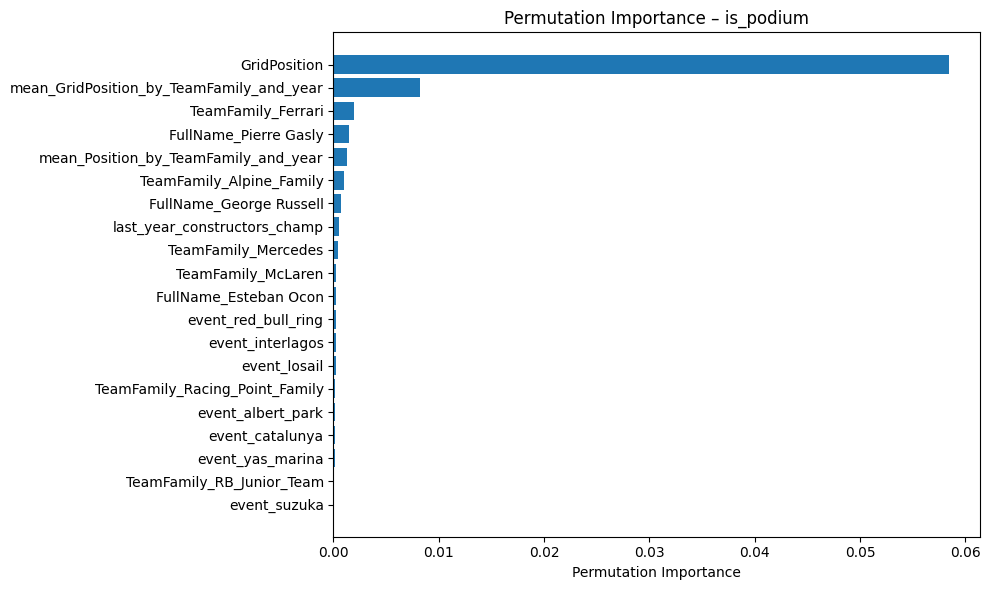


 Partial Dependence on Top 6 Features:
Selected features: ['GridPosition', 'mean_GridPosition_by_TeamFamily_and_year', 'mean_GridPosition_by_TeamFamily_previous_3_observations', 'mean_Position_by_TeamFamily_and_year', 'mean_GridPosition_by_FullName_previous_3_observations', 'mean_Position_by_TeamFamily_previous_3_observations']


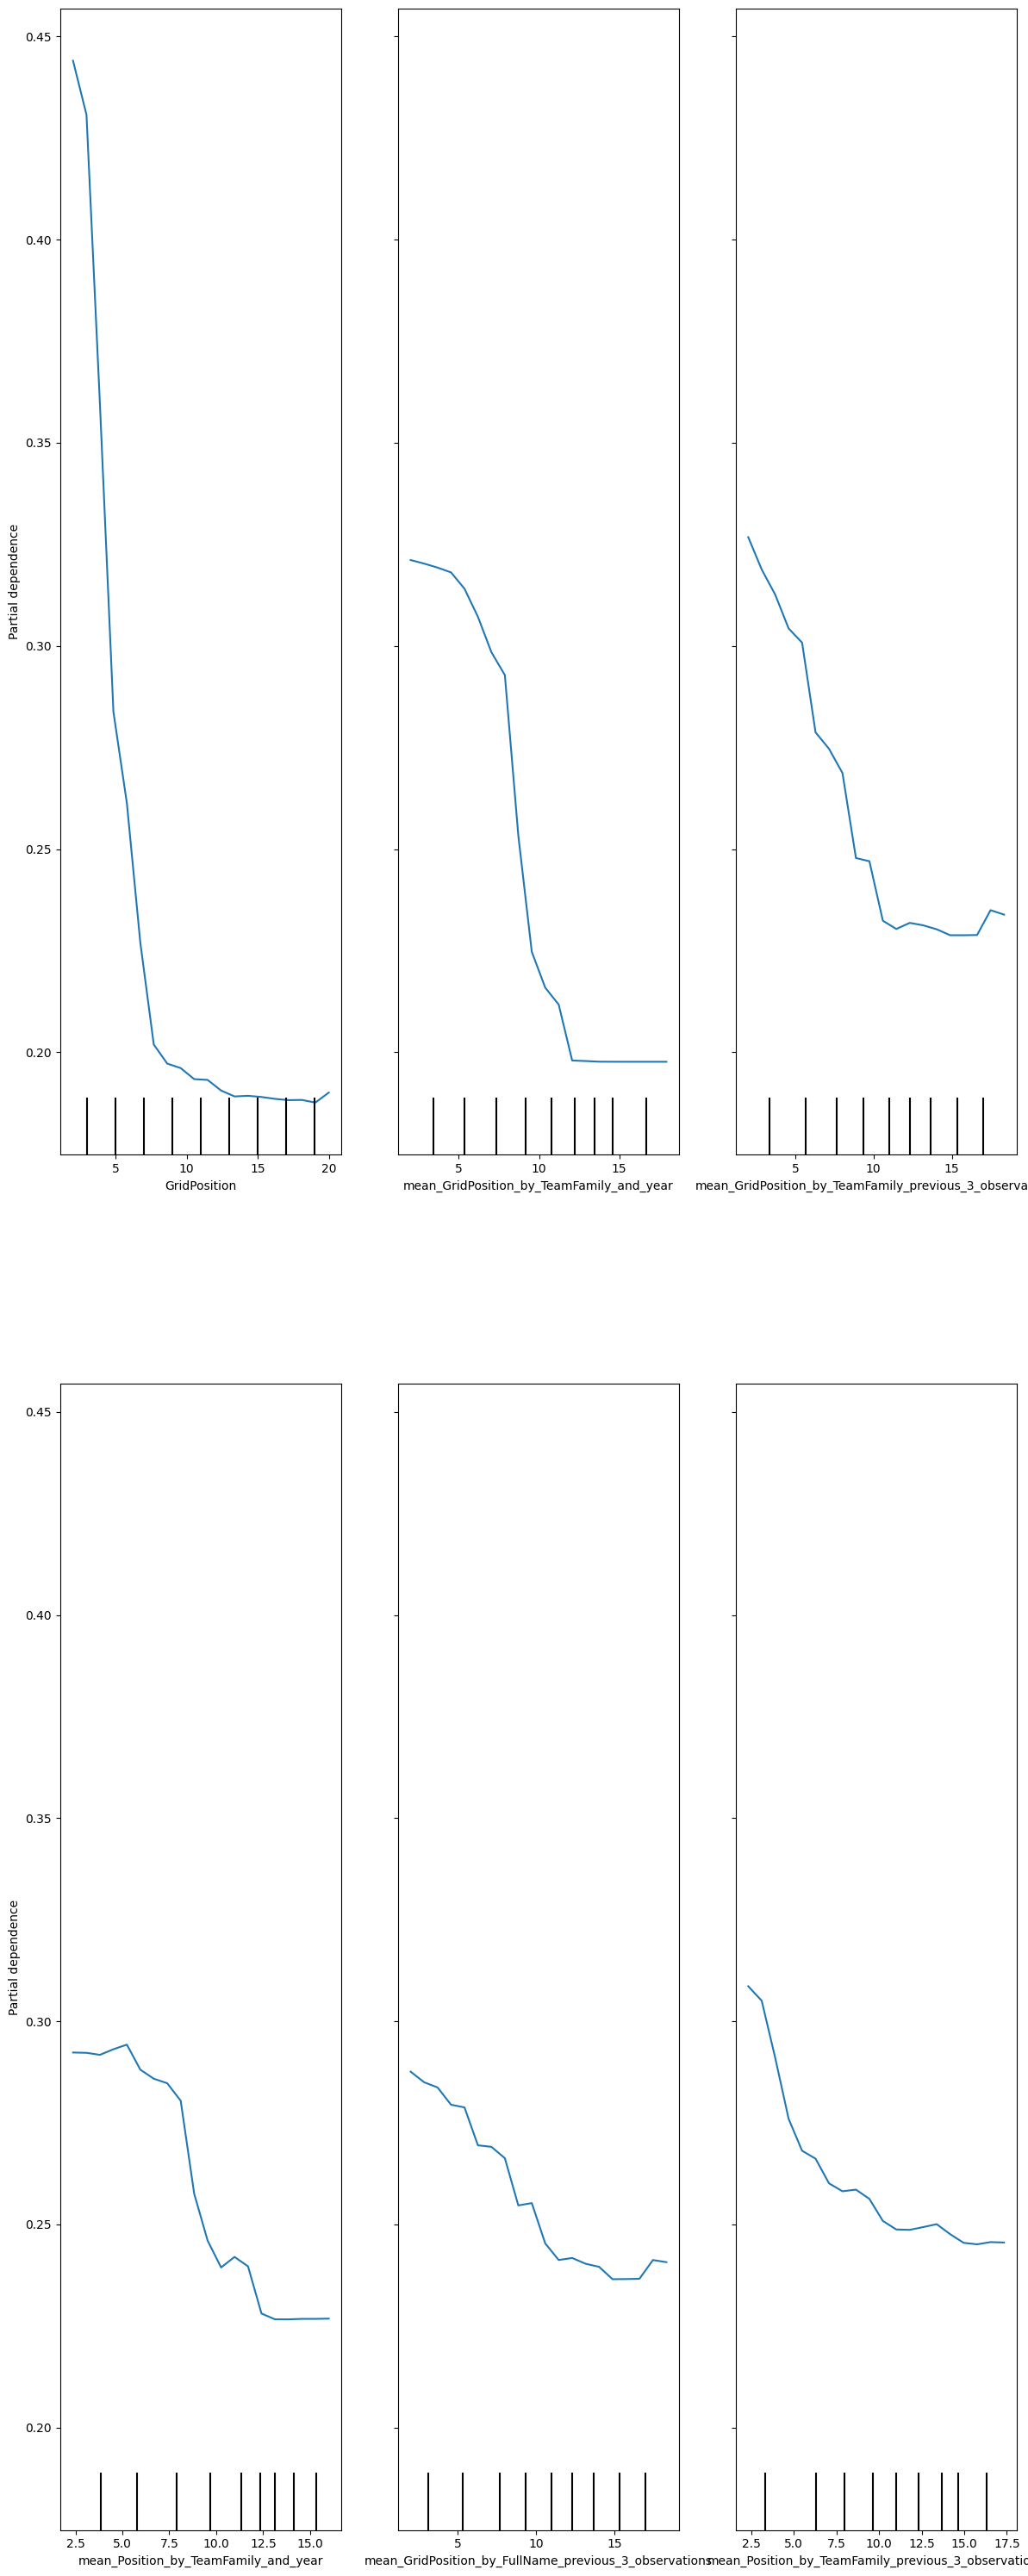

In [ ]:
model_podium, results_podium = run_rf(
    df_path="Data/race_feature_2015_2024.csv",
    target="is_podium",
    param_search=True
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Test Metrics---
Log loss: 0.1782
AUC: 0.9313
Confusion Matrix:
[[420  35]
 [  9  15]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9790    0.9231    0.9502       455
           1     0.3000    0.6250    0.4054        24

    accuracy                         0.9081       479
   macro avg     0.6395    0.7740    0.6778       479
weighted avg     0.9450    0.9081    0.9229       479


Evaluation - Target: is_winner
First place accuracy: 0.375
Podium accuracy: 0.8873
Exact position accuracy: 0.1253

Computing permutation importance...


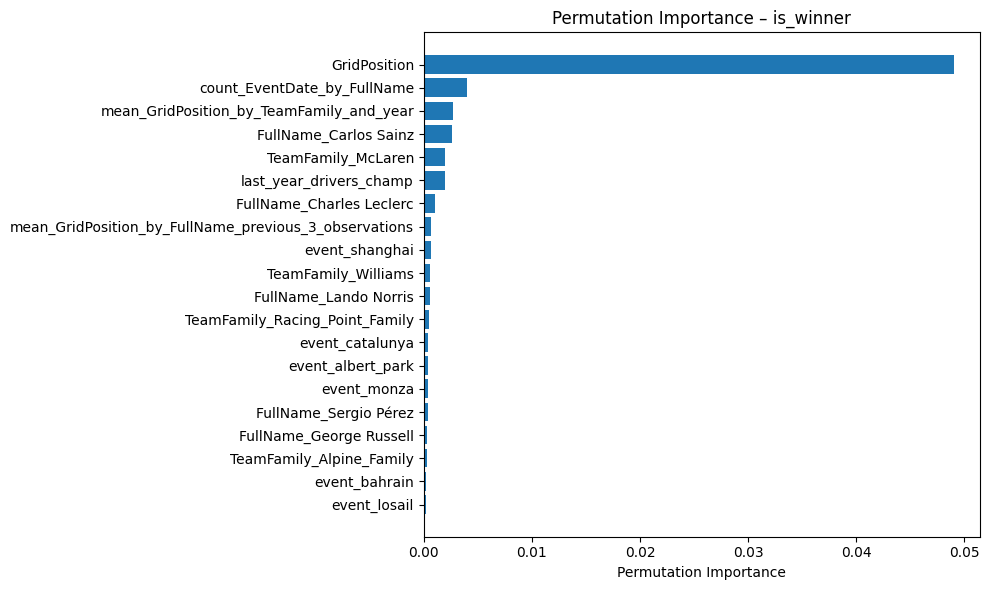


 Partial Dependence on Top 6 Features:
Selected features: ['GridPosition', 'mean_GridPosition_by_TeamFamily_and_year', 'mean_GridPosition_by_TeamFamily_previous_3_observations', 'mean_Position_by_TeamFamily_and_year', 'mean_Position_by_TeamFamily_previous_3_observations', 'mean_Position_by_FullName_previous_3_observations']


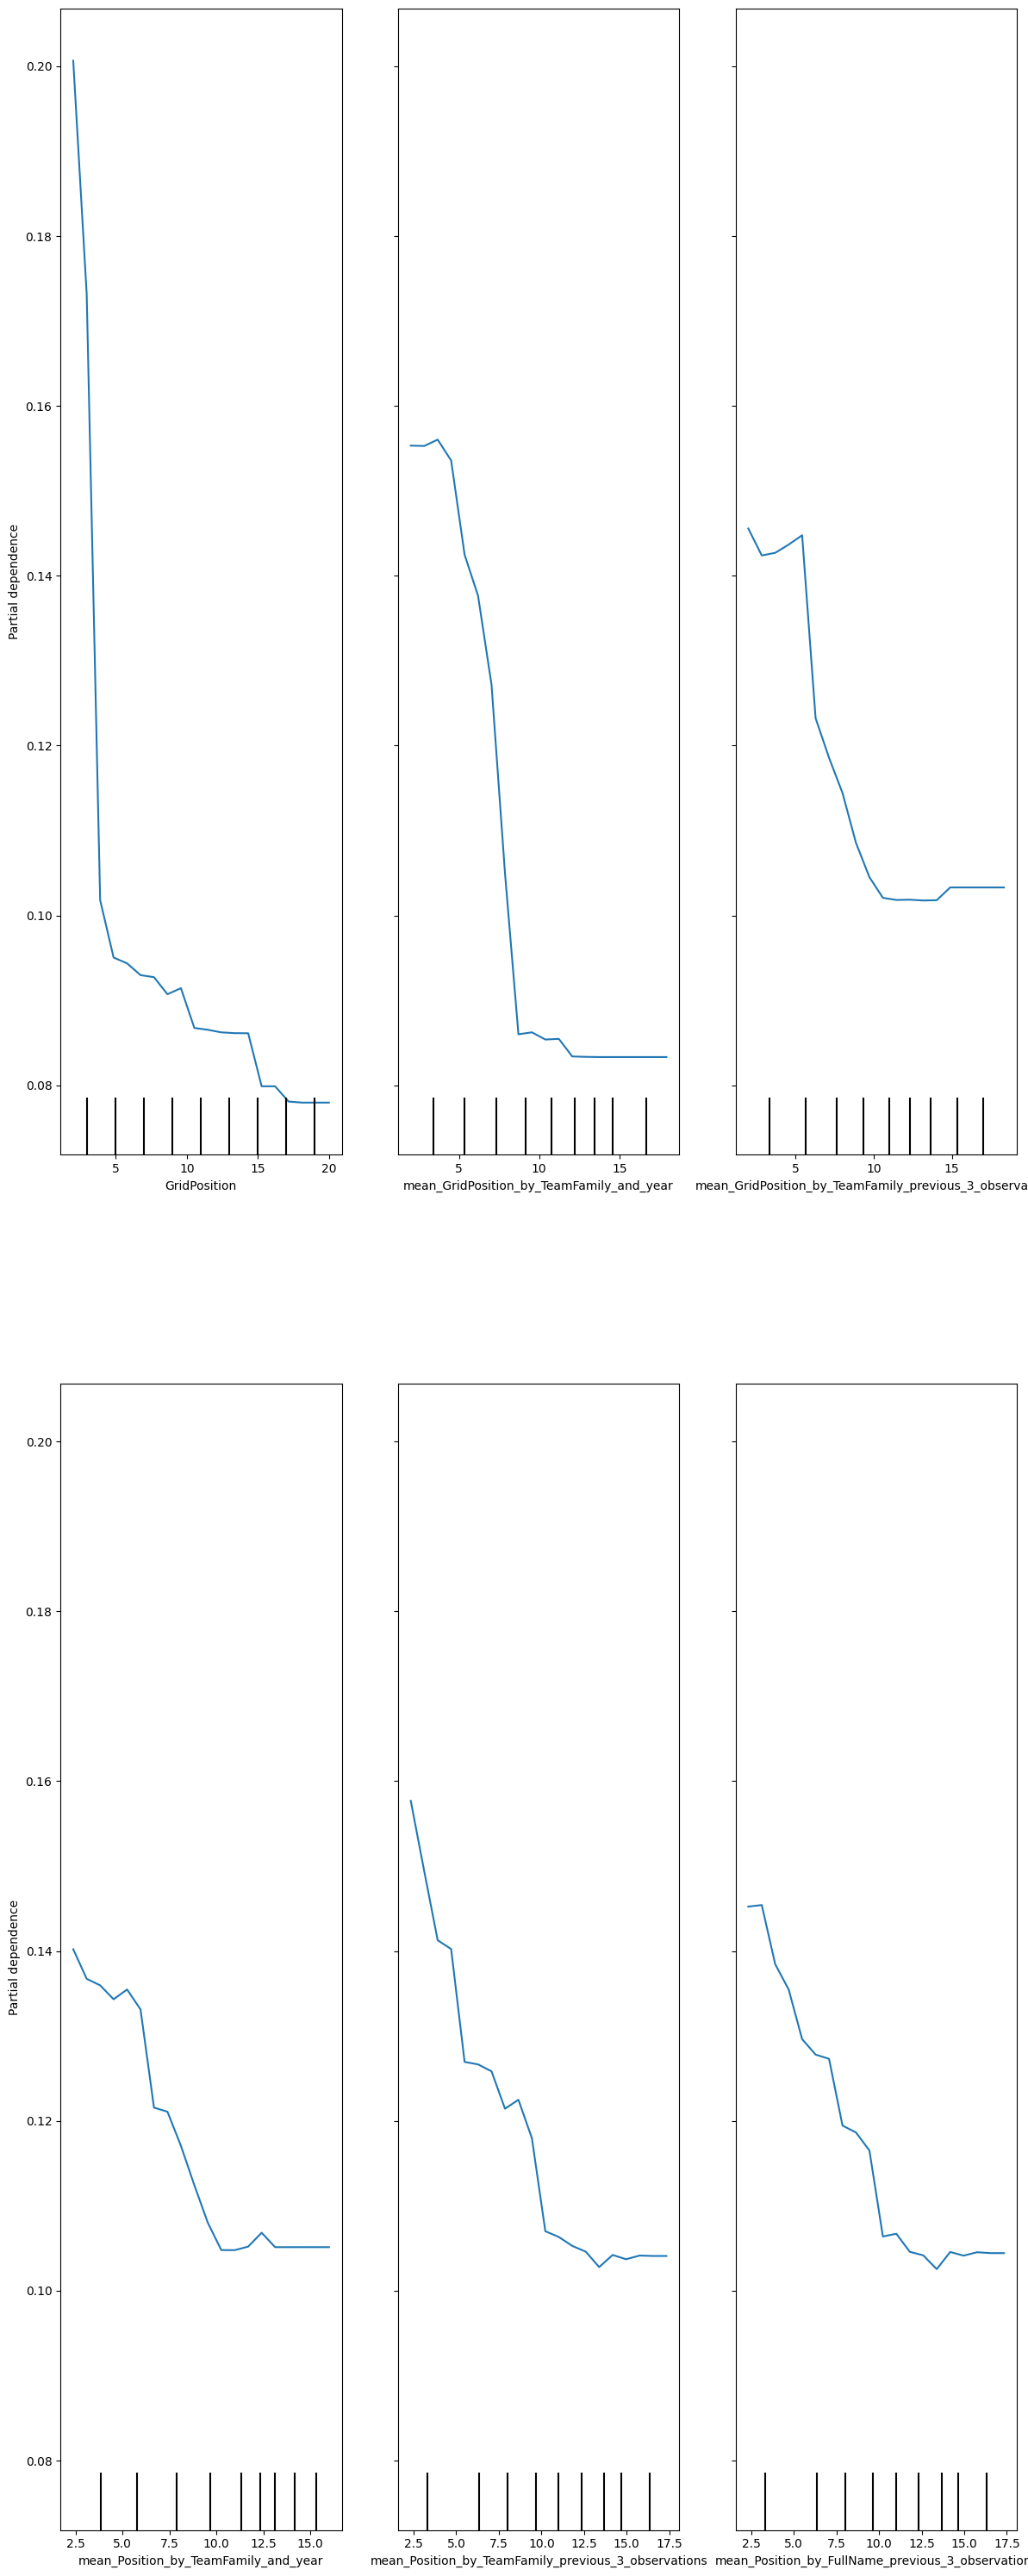

In [ ]:
model_winner, results_winner = run_rf(
    df_path="Data/race_feature_2015_2024.csv",
    target="is_winner",
    param_search=True
)

In [19]:
results_winner["event"].unique()
results_winner[results_winner["event"] == "vegas"]

,FullName,event,year,TeamFamily,GridPosition,Position,prob_is_winner,rank_is_winner,is_podium_actual,is_podium_predicted
166,George Russell,vegas,2024,Mercedes,1,1,0.439423,2.0,True,True
44,Carlos Sainz,vegas,2024,Ferrari,2,3,0.412988,3.0,True,True
404,Pierre Gasly,vegas,2024,Alpine_Family,3,20,0.110501,7.0,False,False
68,Charles Leclerc,vegas,2024,Ferrari,4,4,0.288853,5.0,False,False
329,Max Verstappen,vegas,2024,Red Bull,5,5,0.602608,1.0,False,True
261,Lando Norris,vegas,2024,McLaren,6,6,0.307787,4.0,False,False
476,Yuki Tsunoda,vegas,2024,RB_Junior_Team,7,9,0.009830,11.0,False,False
380,Oscar Piastri,vegas,2024,McLaren,8,7,0.125105,6.0,False,False
353,Nico Hülkenberg,vegas,2024,Haas F1 Team,9,8,0.002348,16.0,False,False
285,Lewis Hamilton,vegas,2024,Mercedes,10,2,0.072990,8.0,True,False


In [15]:
results_winner.to_excel("C:/Users/apidb/OneDrive/Bureau/Lagg/RFwinner.xlsx")
results_podium.to_excel("C:/Users/apidb/OneDrive/Bureau/Lagg/¨RFpodium.xlsx")